In [122]:
%matplotlib widget
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set()

import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal, MultivariateNormal

## Neural Processes++

### Easy case: 2d

We define a function parametrized by neural network:

$$f_\theta : x \rightarrow h$$

We define the parameters $\alpha$ and $\beta$ as generated from by the following diagonal gaussians:

$$p(\alpha | \mu_\alpha, \sigma_\alpha) = \mathcal{N}(\mu_\alpha, \Sigma_\alpha)$$

$$p(\beta | \mu_\beta, \sigma_\beta) = \mathcal{N}(\mu_\beta, \Sigma_\beta)$$


We define the observation model as:

$$ y = \alpha  f(x) + \beta $$

i.e.

$$ y \sim \mathcal{N} \Big(\mu_\alpha f_\theta(x) + \mu_\beta, f_\theta(x)^T \Sigma_\alpha f_\theta(x) + \Sigma_\beta  \Big)$$



Given $\mu = \mu_\alpha f_\theta(x) + \mu_\beta + \mu_\beta $ and $\Sigma = f_\theta(x)^T \Sigma_\alpha f_\theta(x) + \Sigma_\beta$, $K$ being a constant, the likelihood is then defined by:

\begin{equation}
\begin{split}
\log p(\mu_\alpha, \sigma_\alpha,\mu_\beta, \sigma_\beta | y ) &= - \frac{1}{2} \sum_i \big[ \log \Sigma_i + \frac{(y_i - \mu_i)^2}{\Sigma_i} \big] + K
\end{split}
\end{equation}

#### 2d regression

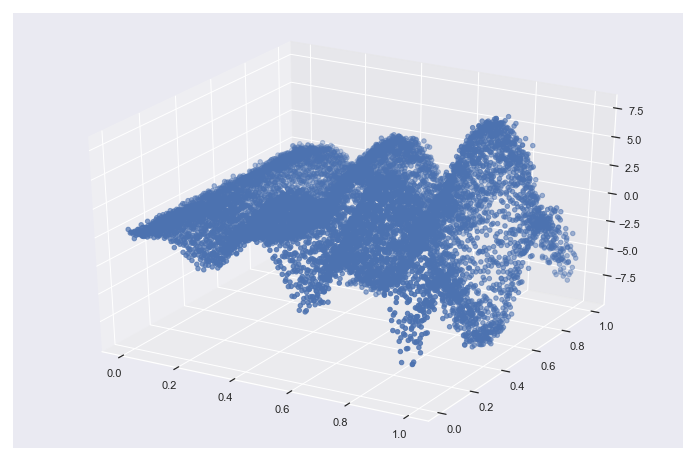

In [123]:
from mpl_toolkits.mplot3d import Axes3D
N = 100
a = 0.5
b = 0.2
scale_x = 0.2
scale_y = 0.3
x = np.linspace(0,1,N)
x,y = np.meshgrid(x,x)
x = np.concatenate([x[:,:,None],y[:,:,None]],2).reshape(-1,2)
gen_y = lambda x_ : 5*x_[:,0]*np.sin(18*x_[:,0]) + scale_x * np.random.normal(size=N**2) + x_[:,0]*4*np.sin(10*x_[:,1] + scale_y * np.random.normal(size=N**2))
#gen_y = lambda x_i : a * f(x_i) + b + scale * np.random.normal()
y = gen_y(x)[:,None]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y)
plt.show()

#### Implement posterior loglikelihood

In [124]:
prior_alpha = Normal(0,1)
prior_beta = Normal(0,1)
mu = lambda h, mu_a, mu_b :  h @ mu_a.t() + mu_b
sigma2 = lambda h, sigma_a, sigma_b: (h @ sigma_a.t())**2 + sigma_b**2
def log_ll(y, mu, sigma_2):
    return -0.5 * ( torch.log(sigma_2) + (y - mu)**2 / sigma_2)
log_prior = lambda y: prior_alpha.log_prob(y) + prior_beta.log_prob(y)
#log_posterior = lambda y, mu, sigma_2 : log_ll(y, mu, sigma_2)

#### Features Extractor, Prior parameters and loss function

In [125]:
class FeaturesExtractor(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.layers = nn.Sequential( nn.Linear(2, 128), nn.ReLU(), nn.Linear(128, h) )
    def forward(self, x):
        return self.layers(x)
    
class Priors(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.mu_a = nn.Parameter(torch.zeros((1,h)))
        self.mu_b = nn.Parameter(torch.tensor(0.))
        self.sigma_a = nn.Parameter(torch.ones((1,h)))
        self.sigma_b = nn.Parameter(torch.tensor(1.))

    def posterior(self, h):
        mu_ = mu(h, self.mu_a, self.mu_b)
        sigma2_ = sigma2(h, self.sigma_a, self.sigma_b)
        return Normal(mu_, sigma2_.sqrt())
        
        
def criterion(h, y, priors):
    mu_ = mu(h, priors.mu_a, priors.mu_b)
    sigma2_ = sigma2(h, priors.sigma_a, priors.sigma_b)
    lp = 0#log_prior(y)
    lll = log_ll(y, mu_, sigma2_)
    return - lll - lp

#### Optimize

In [126]:
h = 8
features = FeaturesExtractor(h)
priors = Priors(h)
l_rate = 0.01
epochs = 5000
optimiser = torch.optim.Adam(list(features.parameters()) + list(priors.parameters()), lr = l_rate) 
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

for epoch in range(epochs):
    epoch +=1
    optimiser.zero_grad()
    h = features.forward(x)
    loss = criterion(h, y, priors)
    loss = loss.mean()
    loss.backward()# back props
    optimiser.step()# update the parameters
    if epoch % 500 == 0:
        print('epoch {}, loss {}'.format(epoch,loss))

epoch 500, loss 0.6839995384216309
epoch 1000, loss 1.4897364377975464
epoch 1500, loss -0.19886521995067596
epoch 2000, loss -0.2338521033525467
epoch 2500, loss -0.23332089185714722
epoch 3000, loss -0.2905753254890442
epoch 3500, loss -0.2612104117870331
epoch 4000, loss -0.298877090215683
epoch 4500, loss -0.19813162088394165
epoch 5000, loss -0.28301572799682617


<Figure size 864x576 with 0 Axes>

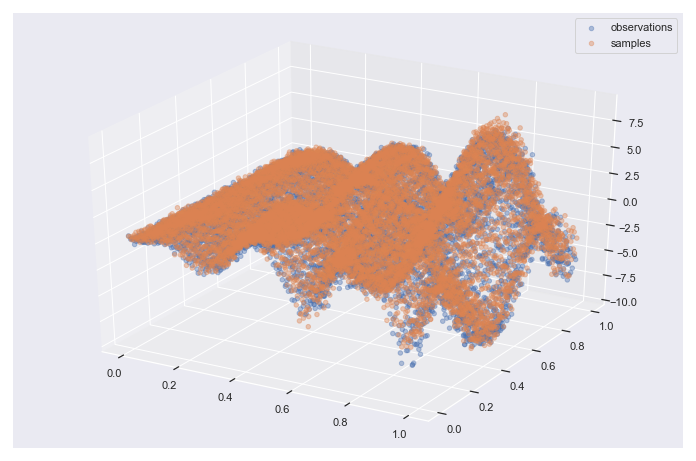

In [127]:
plt.figure(figsize=(12,8))
h = features(x)
p5 = priors.posterior(h).icdf(0.01 * torch.ones_like(priors.mu_b)).detach().numpy()
p95 = priors.posterior(h).icdf(0.99 * torch.ones_like(priors.mu_b)).detach().numpy()
samples = priors.posterior(h).sample().detach().numpy()



fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, alpha=0.4, label='observations')
ax.scatter(x[:,0], x[:,1], samples.squeeze(), alpha=0.4, label='samples')
plt.legend()
plt.show()


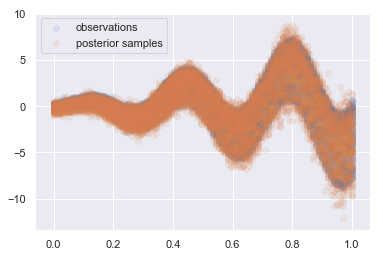

In [97]:
# projection
plt.scatter(x[:, 0],y, alpha=0.1, label='observations')
plt.scatter(x[:, 0],samples, alpha=0.1, label='posterior samples')
#plt.scatter(xx[:, 0],h[:, 0].detach().numpy(), alpha=0.1, label='f(x)')
plt.legend()
plt.show()

In [46]:
p5.max()

tensor(7.9401)